# <center> The PageRank Algorithm </center>
## <center> 3$^{rd}$ Assignment - 4$^{th}$ Notebook </center>
### <center> By Group 80 for the course Advances in Data Mining of the University of Leiden taught by Wojtek Kowalczyk </center>
<center> Lisa Dombrovskij (s1504819) - dombrovskij@strw.leidenuniv.nl </center>
<center> Margherita Grespan (s2233150) - grespan@strw.leidenuniv.nl </center>

***
In this notebook we will explore a method to find the principal eigen vector of transition matrix M. Eventually the goal is to rank the pages. For this, an algorithm called PageRank is used. This algorithm is used by Google to rank their webpages for the search engine. 

As we have seen in a previous notebook, a node in this graph has an average of 12.8 outgoing node. This means that the transition matrix which describes the probability of going from one node to another is a sparse matrix, e.g. in a column -on average- only 10 elements out of 248193 will be non-zero.

It is very straight-forward to create the transition matrix:
1. Put a 1 at every (row, column) non zero combination with the indices equal to the page ID's.
2. Divide each column by the amount of non zero entries in that column, i.e. the amount of outer links, to obtain the probabilities.

The next step is to put the data in a different format that will be used for the PageRank algorithm. The table will consist of three columns: source, degree and destination nodes. The source column contains a page ID, the degree column contains the amount of outgoing edges this node has and the destination nodes column contains the nodes to which the source node links. The information in this table will be used to update the principal eigen vector v of matrix M that we are trying to find.

| source  | degree | destination nodes               |
|---------|--------|-------------------------------|
| 0       | d$_1$  | dest$_{11}$,dest$_{12}$, ..., dest$_{1j}$ |
| 1       | d$_2$   | dest$_{21}$,dest$_{22}$, ..., dest$_{2j}$ |
| . . .   | . . .  | . . .                                     |
| i       | d$_i$   | dest$_{i1}$,dest$_{i2}$, ..., dest$_{ij}$ |

In [5]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.sparse import csc_matrix, diags
import time
np.warnings.filterwarnings('ignore')

In [6]:
with open('prepared_data', 'rb') as f:
    data = pickle.load(f)

The first thing to do is to crate a table containing:


In [7]:
df_destinations=data.groupby('new_page_id_from')['new_page_id_to'].apply(list).reset_index(name='destinations')
df_destinations=df_destinations.rename(columns={"new_page_id_from": "page_id"})

In [8]:
df_destinations.head()

,page_id,destinations
0,0,"[18381, 19179, 18382, 18501, 18502, 18568, 186..."
1,1,"[1, 163504, 1688, 107315, 4265, 31284, 116875,..."
2,2,"[36, 242802, 242715, 22474, 1538, 1557, 243733..."
3,3,"[18439, 18417, 1144, 111438, 103174, 240752, 1..."
4,4,"[18751, 18485, 247205, 18588, 18365, 47251, 33..."


In [9]:
n_nodes = len(pd.unique(data[['new_page_id_from', 'new_page_id_to']].values.ravel('K')))
print('The amount of nodes is: ', n_nodes)

The amount of nodes is:  248193


In [10]:
#counting the num. of connections
temp = pd.DataFrame({'page_id':np.arange(n_nodes)})
n_outgoing_count = data.groupby('new_page_id_from').size().reset_index(name = 'n_outgoing')
n_outgoing = pd.merge(temp, n_outgoing_count, left_on = 'page_id', right_on = 'new_page_id_from', how='outer').fillna(0)
n_outgoing.drop(columns = ['new_page_id_from'], inplace=True)

In [11]:
#Create the transition matrix
m_ones=np.ones(data.shape[0]) #Make ones for links
M=csc_matrix(( m_ones, (data.new_page_id_to.values,data.new_page_id_from.values))) #Create sparse matrix
prob=1/n_outgoing.n_outgoing.values #Calculate probabilities
prob=diags(prob) 
M=np.dot(M,prob)

In [12]:
df_page_rank=pd.merge(n_outgoing, df_destinations, on='page_id', how='outer')

In [13]:
df_page_rank.head()

,page_id,n_outgoing,destinations
0,0,193.0,"[18381, 19179, 18382, 18501, 18502, 18568, 186..."
1,1,21.0,"[1, 163504, 1688, 107315, 4265, 31284, 116875,..."
2,2,22.0,"[36, 242802, 242715, 22474, 1538, 1557, 243733..."
3,3,61.0,"[18439, 18417, 1144, 111438, 103174, 240752, 1..."
4,4,47.0,"[18751, 18485, 247205, 18588, 18365, 47251, 33..."


Above, the first five lines of the table are displayed. We will loop through every row, i.e. every node and use the following update rule:

$v_{new}(dest_{j}) += v_{old}(source_{i}) * \frac{\beta}{d_{i}}$

In which $v_{old}$ is the vector v of the previous iteration and $v_{new}$ the new v. $v_{new}(dest_{j})$ is the element in $v_{new}$ of the $j^{th}$ destination node of the $i^{th}$ source node, $v_{old}(source_{i})$ is the element in $v_{old}$ of source node i, $\beta$ is a constant, usually 0.8 or 0.9 and $d_{i}$ is the degree of the $i^{th}$ source node.

The first $v_{old}$ and $v_{new}$ vectors are intiated to contain the value $\frac{1-\beta}{n_{nodes}}$ with a length of $n_{nodes}$.

In [14]:
beta=.8
v=[]
MSE=[]
t_list=[]
v_old=np.array([(1.0-beta)/n_nodes]*n_nodes) #list of length n_nodes

for c in range(25):
    v_new=np.array([(1.0-beta)/n_nodes]*n_nodes)
    print('iteration n.',c)
    start=time.time()
    
    for i in range(n_nodes):
        source_node = df_page_rank.iloc[i].page_id
        dest=df_page_rank.iloc[i].destinations
        d=df_page_rank.iloc[i].n_outgoing #degree
        
        if d != 0:
            for destj in dest:
                v_new[destj]+=v_old[source_node]*beta/d
    
    v_old=v_new.copy()

    MSE.append(mean_squared_error(v_old, M*v_old))
    end=time.time()
    t=end-start
    t_list.append(t)

iteration n. 0
iteration n. 1
iteration n. 2
iteration n. 3
iteration n. 4
iteration n. 5
iteration n. 6
iteration n. 7
iteration n. 8
iteration n. 9
iteration n. 10
iteration n. 11
iteration n. 12
iteration n. 13
iteration n. 14
iteration n. 15
iteration n. 16
iteration n. 17
iteration n. 18
iteration n. 19
iteration n. 20
iteration n. 21
iteration n. 22
iteration n. 23
iteration n. 24


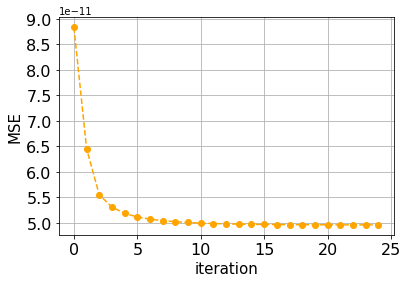

In [15]:
plt.plot(MSE, color='orange', linestyle='--', marker='o')
plt.xlabel('iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

In [16]:
print("MSE after 25 iterations: {}".format(MSE[-1]))

MSE after 25 iterations: 4.957961767510701e-11


Above, the graph shows the MSE over the 25 iterations of the PageRank algorithm.

The MSE converges between 10 and 15 iterations to a value around 4.99e$^{-11}$.
As we can see, the error using the sparse matrix method in notebook 3 is 10$^{-2}$ times smaller than the error obtained with the method in this notebook.

In [20]:
print('On average an iteration takes', round(np.mean(t_list),2),'s')

On average an iteration takes 187.24 s
